In [74]:
# importing libraries 
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error







In [75]:
data = pd.read_csv('E:\COMP2002\insurance_dataset.csv', keep_default_na=False, na_values=['NA', 'na', 'NULL'])

In [76]:
data_encoded = pd.get_dummies(data, columns=['gender', 'smoker', 'region', 'medical_history', 'family_medical_history'])

for column in data_encoded.columns:
    if data_encoded[column].dtype == 'bool':
        data_encoded[column] = data_encoded[column].astype(int)

In [77]:
# Define the mapping for each column based on the given order.
ordinal_mappings = {
    'exercise_frequency': {'Never': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3},
    'occupation': {'Unemployed': 0, 'Student': 1, 'Blue collar': 2, 'White collar': 3},
    'coverage_level': {'Basic': 0, 'Standard': 1, 'Premium': 2}
}



for column, mapping in ordinal_mappings.items():
    data_encoded[column] = data_encoded[column].map(mapping)


In [78]:
features = data_encoded.drop(columns=['charges', 'coverage_level'])
coverage_level = data_encoded['coverage_level']
charges = data_encoded['charges']



In [79]:
print(data_encoded.dtypes)

age                                             int64
bmi                                           float64
children                                        int64
exercise_frequency                              int64
occupation                                      int64
coverage_level                                  int64
charges                                       float64
gender_female                                   int32
gender_male                                     int32
smoker_no                                       int32
smoker_yes                                      int32
region_northeast                                int32
region_northwest                                int32
region_southeast                                int32
region_southwest                                int32
medical_history_Diabetes                        int32
medical_history_Heart disease                   int32
medical_history_High blood pressure             int32
medical_history_None        

In [80]:

X_train, X_test, y_coverage_train, y_coverage_test, y_charges_train, y_charges_test = train_test_split(
    features, coverage_level, charges, test_size=0.1, random_state=42)


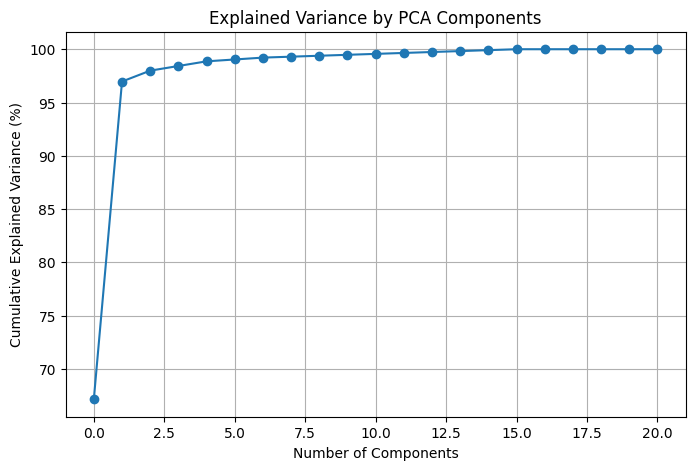

[ 67.15538577  96.96903686  97.98919474  98.42643722  98.86306127
  99.0379806   99.21289283  99.30072445  99.38845578  99.47600807
  99.56352774  99.65093322  99.73828129  99.82561269  99.91291216
 100.         100.         100.         100.         100.
 100.        ]


In [81]:
# Assuming 'inputs' is your pre-processed dataset (excluding the target variable)
pca = PCA().fit(features)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_) * 100

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Optionally, print the cumulative explained variance
print(cumulative_explained_variance)

In [82]:
# Initialize the scaler
scaler_X = StandardScaler()
scaler_y_coverage = StandardScaler()
scaler_y_charges = StandardScaler()

# Scale features
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale targets
y_coverage_train_scaled = scaler_y_coverage.fit_transform(y_coverage_train.values.reshape(-1, 1)).ravel()
y_coverage_test_scaled = scaler_y_coverage.transform(y_coverage_test.values.reshape(-1, 1)).ravel()
y_charges_train_scaled = scaler_y_charges.fit_transform(y_charges_train.values.reshape(-1, 1)).ravel()
y_charges_test_scaled = scaler_y_charges.transform(y_charges_test.values.reshape(-1, 1)).ravel()

# Initialize PCA
pca = PCA(n_components=2)  # Use the appropriate number of components

# Apply PCA to features
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [83]:
# Initialize and train the model for charges prediction
charges_model = MLPRegressor(
    hidden_layer_sizes=(100, 100),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=1e-4,
    random_state=42,
    verbose=True
)

charges_model.fit(X_train_pca, y_charges_train_scaled)

# Predict charges
charges_pred_train = charges_model.predict(X_train_pca)
charges_pred_test = charges_model.predict(X_test_pca)

# Add the charges predictions as a feature
X_train_enhanced = np.hstack((X_train_pca, charges_pred_train.reshape(-1, 1)))
X_test_enhanced = np.hstack((X_test_pca, charges_pred_test.reshape(-1, 1)))

print("X_train_enhanced shape:", X_train_enhanced.shape)

# Initialize and train the model for coverage prediction
coverage_model = MLPClassifier(
    hidden_layer_sizes=(100, 100),  # same structure: two layers with 100 units each
    activation='relu',  # using rectified linear unit activation function
    solver='adam',  # default solver works well for relatively large datasets
    alpha=0.001,  # regularization term, may need to be adjusted
    learning_rate='adaptive',  # learning rate is reduced when learning stalls
    learning_rate_init=0.001,  # initial learning rate
    max_iter=1000,  # maximum number of iterations
    early_stopping=True,  # to prevent overfitting
    validation_fraction=0.1,  # fraction of training data to use as validation
    n_iter_no_change=10,  # number of iterations with no improvement to wait before stopping
    tol=1e-4,  # tolerance for the optimization
    random_state=42,  # for reproducibility
    verbose=True
)

# Assuming X_train_pca and y_coverage_train are already defined and preprocessed appropriately
coverage_model.fit(X_train_pca, y_coverage_train)

# Predict coverage
coverage_pred_train = coverage_model.predict(X_train_pca)
coverage_pred_test = coverage_model.predict(X_test_pca)

# Evaluate the coverage model
accuracy = accuracy_score(y_coverage_test, coverage_pred_test)
print(f"Test accuracy for coverage prediction: {accuracy}")
print(classification_report(y_coverage_test, coverage_pred_test))

Iteration 1, loss = 0.15550937
Validation score: 0.693582
Iteration 2, loss = 0.15323608
Validation score: 0.694939
Iteration 3, loss = 0.15275505
Validation score: 0.695635
Iteration 4, loss = 0.15237602
Validation score: 0.695688
Iteration 5, loss = 0.15213587
Validation score: 0.695914
Iteration 6, loss = 0.15192794
Validation score: 0.695859
Iteration 7, loss = 0.15170924
Validation score: 0.696806
Iteration 8, loss = 0.15141777
Validation score: 0.698186
Iteration 9, loss = 0.15099796
Validation score: 0.698296
Iteration 10, loss = 0.15036265
Validation score: 0.699953
Iteration 11, loss = 0.14914740
Validation score: 0.705662
Iteration 12, loss = 0.14699724
Validation score: 0.707290
Iteration 13, loss = 0.14445350
Validation score: 0.713373
Iteration 14, loss = 0.14235294
Validation score: 0.714349
Iteration 15, loss = 0.14064278
Validation score: 0.719592
Iteration 16, loss = 0.13914587
Validation score: 0.726113
Iteration 17, loss = 0.13801377
Validation score: 0.720227
Iterat

e:\Applications\Python3.11\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Applications\Python3.11\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Applications\Python3.11\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [84]:
# Convert the negative MSE scores to positive
positive_MLP_cv_scores = -MLP_cv_scores

# Plotting the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(positive_MLP_cv_scores)
plt.title("Boxplot of Cross-Validation MSE Scores")
plt.ylabel("Mean Squared Error (MSE)")
plt.xticks([1], ['MLP Regressor'])
plt.grid(True)

# Display the plot
plt.show()

NameError: name 'MLP_cv_scores' is not defined